In [3]:
# zeroth step.
# convert the zip downloaded into something that rasterio can operate
import os
import zipfile

filename = 'data/gt30w140n90_dem.zip'

with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('extracted')

# Check contents of the extracted folder
extracted_files = os.listdir('extracted')
print("Extracted files:", extracted_files)

# Extracted files: ['gt30w140n90.prj', 'gt30w140n90.dem', 'gt30w140n90.src', 'gt30w140n90.gif', 'gt30w140n90.stx', 'gt30w140n90.hdr', 'gt30w140n90.dmw', 'gt30w140n90.sch']




Extracted files: ['gt30w140n90.prj', 'gt30w140n90.dem', 'gt30w140n90.src', 'gt30w140n90.gif', 'gt30w140n90.stx', 'gt30w140n90.hdr', 'gt30w140n90.dmw', 'gt30w140n90.sch']


In [6]:
# first steps.
# import the DEM file
import rasterio


with rasterio.open('extracted/gt30w140n90.dem') as src:
    print(src.width, src.height)
    print(src.crs)
    print(src.transform)
    print(src.count)
    print(src.indexes)
    elevation = src.read(1)
    
print(len(elevation))
print(len(elevation[0]))





4800 6000
EPSG:4326
| 0.01, 0.00,-140.00|
| 0.00,-0.01, 90.00|
| 0.00, 0.00, 1.00|
1
(1,)
6000
4800


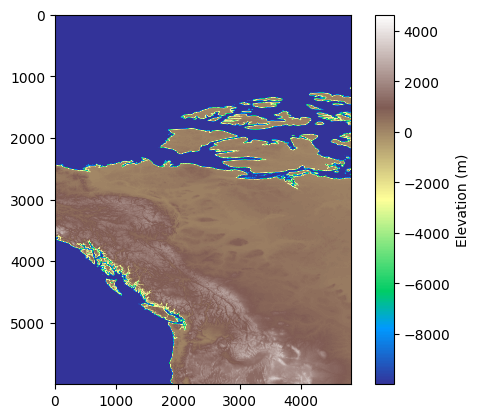

In [10]:
import matplotlib.pyplot as plt

plt.imshow(elevation, cmap='terrain')
plt.colorbar(label='Elevation (m)')
plt.show()

In [21]:
# the elevation data looks pretty juicy,
# but there's a ton of not relevant data. I'd like
# to slice this down to just the 20 mile radius around the mountain peak.
# better slices might be possible - based on grouping mountains together with elevation? split at the saddles, valleys?
mt_center_north = 46.8515342
mt_center_east = -121.7802034


In [22]:
# it will be interesting to just find the highest value in the set , and what offset it is at.
best = -9999
coords = (0,0)
for lat_idx, longs in enumerate(elevation):
    for long_idx, val in enumerate(longs):
        if val > best:
            best = val
            coords = (lat_idx, long_idx)
print(best)
print(coords)


4635
(3559, 36)


In [24]:
# the boundaries of the measured area start at -140, 90N, and with the 30 arcsecond precision, we should see 
# 1 degree / 60 arc minute * (30 arc second precision * (1 arc minute / 60 arc second)) = 1/120 degree per entry ->
# which 6000 / 120 = vertical number of degrees extent of data = 50 degrees.
# So the southernmost data will be at 40 degrees 30 seconds N
# and the easternmost data will be at -100º 30" (east, i guess?)

# so let's convert from the `coords` to an absolute coord.

def index_to_absolute_coord(index):
    vertical_bound = 90
    horizontal_bound = -140
    resolution = 30 / 3600 # measurements per degree

    decimal_v = vertical_bound - (index[0] * resolution)
    decimal_h = horizontal_bound + (index[1] * resolution)
    return (decimal_v, decimal_h)

print(index_to_absolute_coord(coords))

(60.34166666666667, -139.7)


In [25]:
# cool. that mountain is right on the canada US border here: https://www.google.com/maps/place/60%C2%B020'30.0%22N+139%C2%B042'00.0%22W/@60.341341,-139.7032846,14.89z/data=!4m4!3m3!8m2!3d60.3416667!4d-139.7!5m1!1e4?entry=ttu
# the topo checks out too - right around 4600 meters.
# now, we need to work backwards - instead of finding the top peak, we need to work from the center of mt ranier.
# let's find the centermost indices from the data to our peak.
def abs_coord_to_index(lat, long):
    resolution = 30 / 3600
    lat_bound = 90
    long_bound = -140


    lat_index = int((lat_bound - lat) / resolution)
    long_index = int((long - long_bound) / resolution)

    return lat_index, long_index

mt_coords = abs_coord_to_index(mt_center_north, mt_center_east)

print(mt_coords)
# double check
print(index_to_absolute_coord(mt_coords))
print(elevation[mt_coords[0]][mt_coords[1]])


(5177, 2186)
(46.858333333333334, -121.78333333333333)
3569


In [29]:
# what is the error from the absolute coords to the calculated coords?
calc_coords = index_to_absolute_coord(mt_coords)
vert_err = mt_center_north - calc_coords[0]
hor_err = mt_center_east - calc_coords[1]

print("vertical error:", vert_err)
print("horizontal error:", hor_err)

vertical error: -0.006799133333331042
horizontal error: 0.003129933333326562


In [30]:
# this is pretty good, what's that distance in a non-angular coordinate system?
# meters?
import math

def degrees_to_meters(lat_deg, long_deg, latitude):
    # Constants
    meters_per_degree_latitude = 111000  # meters per degree of latitude

    # Convert latitude degrees to meters (constant)
    lat_meters = lat_deg * meters_per_degree_latitude

    # Convert longitude degrees to meters (varies with latitude)
    meters_per_degree_longitude = 111000 * math.cos(math.radians(latitude))
    long_meters = long_deg * meters_per_degree_longitude

    return lat_meters, long_meters

print(degrees_to_meters(vert_err, hor_err, mt_center_north))

(-754.7037999997457, 237.59924648974842)


In [35]:
# the error distance is expected, and within reasonable values, since we know the resolution of
# 30 arc seconds is around 925 meters in longitude.

# however, this elevation of 3569m is less than expected. we know mt ranier is >14k ft & 3570 meters is only 11700 ft.
# it seems like maybe a plot of a constrained slice near this point would be a good starting point.
import numpy as np

np_elevation = np.array(elevation)
radius = 30 # 20 miles * 30 arcseconds * 2pi

# rect coords
start_x = max(mt_coords[1] - radius, 0)
end_x = min(mt_coords[1] + radius + 1, 4800)  # +1 to include the end point
start_y = max(mt_coords[0] - radius, 0)
end_y = min(mt_coords[0] + radius + 1, 6000)

rect_slice = np_elevation[start_y:end_y, start_x:end_x]
print(start_x, end_x)
print(start_y, end_y)
print(rect_slice)



2156 2217
5147 5208
[[ 304  363  365 ... 1092  877  997]
 [ 346  357  424 ... 1231 1084 1011]
 [ 420  430  425 ... 1375 1388 1192]
 ...
 [ 864  866  865 ... 1213 1322 1292]
 [ 889  869  885 ... 1449 1643 1599]
 [1013  951  952 ... 1174 1211 1348]]


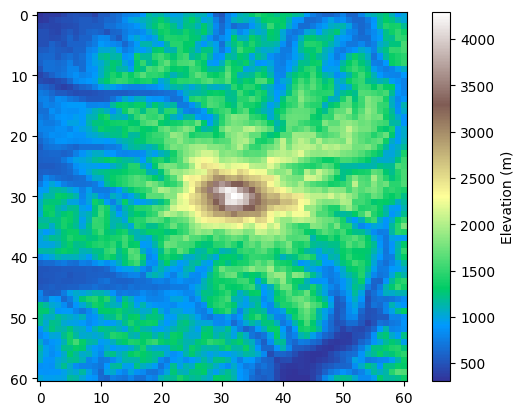

In [36]:
plt.imshow(rect_slice, cmap='terrain')
plt.colorbar(label='Elevation (m)')
plt.show()

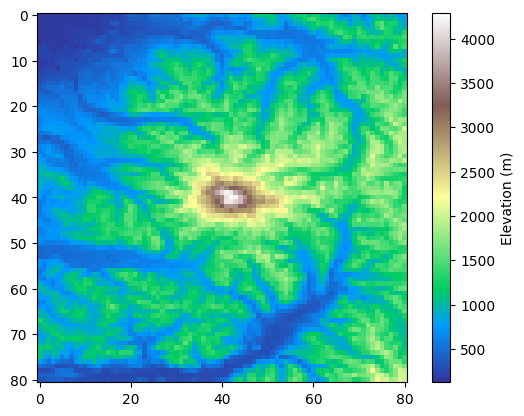

In [42]:
# redefine in a nice little func

def get_elev_slice(elevation: np.array, center_coord: tuple, radius):
    start_x = max(center_coord[1] - radius, 0)
    end_x = min(center_coord[1] + radius + 1, 4800)  # +1 to include the end point
    start_y = max(center_coord[0] - radius, 0)
    end_y = min(center_coord[0] + radius + 1, 6000)

    rect_slice = elevation[start_y:end_y, start_x:end_x]
    return rect_slice


plt.imshow(get_elev_slice(elevation, mt_coords, 40), cmap='terrain')
plt.colorbar(label='Elevation (m)')
plt.show()

In [43]:
# try circle slice?
def get_circular_slice(slice, radius):
    """Replace outside of mask with np.nan"""
    x, y = np.ogrid[:slice.shape[1], :slice.shape[0]]
    center_x_slice = min(mt_coords[1], radius)
    center_y_slice = min(mt_coords[0], radius)
    mask = (x - center_x_slice)**2 + (y - center_y_slice)**2 > radius**2
    slice[mask] = np.nan
    return slice


forty_rect = get_elev_slice(elevation, mt_coords, 40)
circle = get_circular_slice(forty_rect, 40)

plt.imshow(circle, cmap='terrain')
plt.colorbar(label='Elevation (m)')
plt.show()

ValueError: cannot convert float NaN to integer

In [ ]:
# 